# Sample portfolio 1

This notebook runs through the library on the one of the examples in the __'sample_portfolio2'__

At the end we optimize to get the results of all the 8 different views

First we import everything

In [26]:
import pandas as pd 
import numpy as np
from entropy_pooling import views
from entropy_pooling import entropy_minimizer
from entropy_pooling import markoviz_optimizer

Then we get the data

In [27]:
data_raw = pd.read_excel("data/data.xlsx").dropna(axis=1, how='all')
weights = data_raw[["Weight"]]
scenarios = data_raw.drop(columns = ["Weight"])/100

We load the vies

In [28]:
(A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx", views_subsheet_name = 0);

We create the posterior distribution

In [29]:
c = 1
p = np.array(weights)
m,n = p.shape

posterior = entropy_minimizer.full_confidence_posterior(p, A, b, C, d, verbose = True)
weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)



Results
Optimal dual variable values:  [13.53605739  1.34753312]
Jacobian matrix at optimum [-3.73591555e-06  8.51736407e-06]


We get the deltas and create the asset space. Additionally, we import the additional constraints for the markoviz optimization

In [30]:
deltas, asset_names = markoviz_optimizer.load_asset_deltas("data/sample_portfolio2_deltas.xlsx")

asset_scenarios = markoviz_optimizer.asset_scenarios(scenarios, deltas, asset_names)

loaded_constraints = pd.read_excel("data/sample_portfolio2_constrs.xlsx").dropna(axis=1, how='all')
manual_constraints = (loaded_constraints.iloc[:,:-2],
                      loaded_constraints.iloc[:,-2],
                      loaded_constraints.iloc[:,-1])

total = 417000000

And finally we do markowitz optimization on the posterior distribution and plot the outcome.

We minimize the volatility at return $\mu_0 = 0.5$ and do not allow for shorting.

The optimization was succesful: False
The optimization was terminated due to: 
Iteration limit reached
Global Equities: -1.0
DM Equities: -0.0
EM Equities: 7819728.0
European Equities: 225814.0
US Equities: 30550838.0
EUR Money Markets: 179896749.0
EUR Government Bonds: 83399999.0
EUR Covered Bonds: 76047125.0
EUR Investment Grade Corporate Bonds: 16915341.0
European High Yield Corporate Bonds: -0.0
EMD Hard Currency: -0.0
Hedge Funds: 22144406.0
Listed Private Equity: -0.0


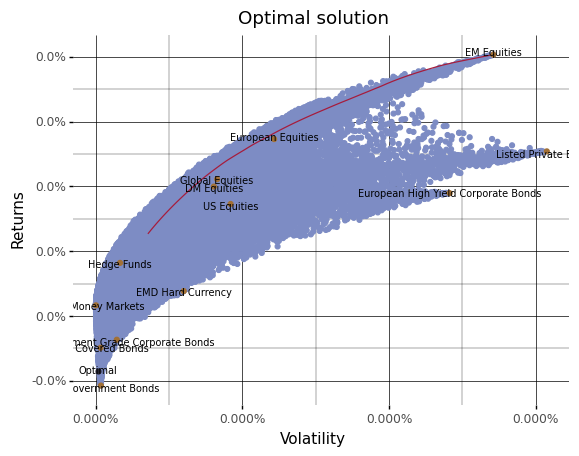

In [31]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = 0,
                                         total = total,
                                         manual_constraints = manual_constraints,
                                         allow_shorting = False,
                                         visualize = True,
                                         verbose = 1).x

for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

We can compare the optimization of the posterior distribution with the prior below

The optimization was succesful: False
The optimization was terminated due to: 
Iteration limit reached
Global Equities: 1.0
DM Equities: 0.0
EM Equities: -0.0
European Equities: -2.0
US Equities: 6704486.0
EUR Money Markets: 110528785.0
EUR Government Bonds: 129995151.0
EUR Covered Bonds: 82099126.0
EUR Investment Grade Corporate Bonds: 55284097.0
European High Yield Corporate Bonds: 0.0
EMD Hard Currency: 4.0
Hedge Funds: 32388350.0
Listed Private Equity: 1.0


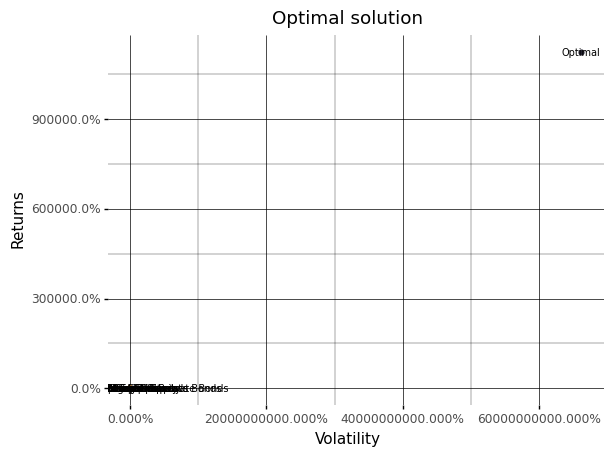

In [32]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         weights,
                                         mu_0 = 0,
                                         manual_constraints = manual_constraints,
                                         allow_shorting = False,
                                         visualize = True,
                                         verbose = 1).x

for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

In [42]:
result = pd.DataFrame(columns = range(8), index =['Result','Optimi', *asset_names])
weights_pos = pd.DataFrame(columns = range(8))
for i in range(8):
  (A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx", views_subsheet_name = i);
  c = 1                 #scenario probability
  p = np.array(weights)
  m,n = p.shape

  posterior = entropy_minimizer.full_confidence_posterior(p, A,b,C,d)
  weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)
  weights_pos.iloc[:,i] = weighted_posterior
  optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                           weighted_posterior,
                                           mu_0 = 0.5,
                                           manual_constraints = manual_constraints,
                                           allow_shorting = True,
                                           visualize = False,
                                           verbose = 0)
  result.iloc[0,i] = optimal.success
  result.iloc[1,i] = optimal.fun / total**2
  result.iloc[2:,i] = np.round(optimal.x, decimals= 0)
result
  

d:\Users\Christian Segercrant\Documents\GitHub\entropy-poolin\entropy_pooling\entropy_minimizer.py:51: RuntimeWarning: divide by zero encountered in log
d:\Users\Christian Segercrant\Documents\GitHub\entropy-poolin\entropy_pooling\entropy_minimizer.py:51: RuntimeWarning: invalid value encountered in matmul
d:\Users\Christian Segercrant\Documents\GitHub\entropy-poolin\entropy_pooling\entropy_minimizer.py:64: RuntimeWarning: overflow encountered in exp
d:\Users\Christian Segercrant\Documents\GitHub\entropy-poolin\entropy_pooling\entropy_minimizer.py:64: RuntimeWarning: invalid value encountered in multiply
d:\Users\Christian Segercrant\Documents\GitHub\entropy-poolin\entropy_pooling\entropy_minimizer.py:66: RuntimeWarning: overflow encountered in exp
d:\Users\Christian Segercrant\Documents\GitHub\entropy-poolin\entropy_pooling\entropy_minimizer.py:66: RuntimeWarning: invalid value encountered in multiply
d:\Users\Christian Segercrant\Documents\GitHub\entropy-poolin\entropy_pooling\entrop

,0,1,2,3,4,5,6,7
Result,True,False,True,False,False,False,True,False
Optimi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Global Equities,5221239.0,1.0,9199726.0,499.0,0.0,-0.0,0.0,0.0
DM Equities,6968123.0,0.0,11412165.0,88.0,0.0,-0.0,-0.0,0.0
EM Equities,1112269.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
European Equities,74014.0,-2.0,0.0,0.0,183093.0,-0.0,0.0,-1.0
US Equities,13619209.0,6704486.0,21088110.0,6709280.0,3318080.0,0.0,527242.0,6704487.0
EUR Money Markets,57644903.0,110528785.0,56872411.0,110449249.0,82265160.0,159213365.0,102047353.0,110528785.0
EUR Government Bonds,116112085.0,129995152.0,119655081.0,130047423.0,159997701.0,83400000.0,108963958.0,129995152.0
EUR Covered Bonds,54668632.0,82099126.0,58223909.0,82093716.0,89788957.0,102785507.0,113185044.0,82099127.0
